## Setting Up the Libs and SEAM Arid Configurations

In [1]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import deepwave
from deepwave import elastic
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 10                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = [20,20]                  # step interval along x/z direction
dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 180                   # model shape of z dimension (depth) SEAM Arid
ny        = 400                   # model shape of y dimension SEAM Arid
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 20                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 199        # number of receivers per shot
source_spacing = np.floor(dx[0] * ny / (num_shots+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx[0] * ny / (num_receivers_per_shot +1))         # space intervel between neigbouring receivers
source_depth = 2 * dx[0]               # the index depth of sources, default is 0
receiver_depth = 2 * dx[0]             # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [0,10,10,10]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

fwi_lrp            = 15        # learning rate for updating the model.
fwi_lrs            = 10        # learning rate for updating the model.
fwi_lrrho            = 2        # learning rate for updating the model.

fwi_batch         =   num_shots      # number of batches for FWI.
fwi_num_epochs    = 200       # number of FWI iteration.
sim_lr            = 1*1e-5   # learning rate for Soamese network.
survey_pad = None
savepoch = 50                 # Saving models each 50 FWI iterations

d_source = np.floor( dx[0]*(ny / (num_shots+1)) )    # 20 * 4m = 80m
first_source = 25*dx[0]  # 10 * 4m = 40m

d_receiver = np.floor( dx[0]*(ny / (num_receivers_per_shot)) )    # 6 * 4m = 24m
first_receiver = 1*dx[0]  # 0 * 4m = 0m


In [2]:
d_source, d_receiver, first_receiver

(380.0, 40.0, 20)

##   Check Cuda Device 


In [3]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Creating Data Pathes and Observed Data

In [4]:
from scipy.ndimage import gaussian_filter

fwi_result = 'results/Aridfwi_pwt_1e-5_5_2_1_shallow_normalize_vertical/'
# Check if the directory exists
if not os.path.exists(fwi_result):
    # Create the directory
    os.makedirs(fwi_result)
    print(f"Directory '{fwi_result}' created.")
else:
    print(f"Directory '{fwi_result}' already exists.")
    
model_true_vp = torch.from_numpy(np.load('data/vp_arid_shallow.npy').reshape(400,180)).float().to(device).T
model_true_vs = torch.from_numpy(np.load('data/vs_arid_shallow.npy').reshape(400,180)).float().to(device).T
model_true_rho = torch.from_numpy(np.load('data/rho_arid_shallow.npy').reshape(400,180)).float().to(device).T




# Shift the value range
model_true_vp = denormalize_vp(normalize_vp(model_true_vp, vmin=model_true_vp.min(), vmax=model_true_vp.max()))
model_true_vs = denormalize_vs(normalize_vs(model_true_vs, vmin=model_true_vs.min(), vmax=model_true_vs.max()))
model_true_rho = denormalize_rho(normalize_rho(model_true_rho, vmin=model_true_rho.min(), vmax=model_true_rho.max()))

print(model_true_vp.shape)

# Mask water column
mask = torch.ones_like(model_true_vp).to(device)

# Smoothed initial model
model_vp = torch.from_numpy(gaussian_filter(model_true_vp.detach().cpu().numpy(), sigma=[15,30])).to(device)
model_vs = torch.from_numpy(gaussian_filter(model_true_vs.detach().cpu().numpy(), sigma=[15,30])).to(device)
model_rho = torch.from_numpy(gaussian_filter(model_true_rho.detach().cpu().numpy(), sigma=[15,30])).to(device)




# Loading the true model
model_init_vp = model_vp
# The model will be updated during FWI
model_vp = torch.nn.Parameter(model_vp)

# Loading the true model
model_init_vs = model_vs
# The model will be updated during FWI
model_vs = torch.nn.Parameter(model_vs)

# Loading the true model
model_init_rho = model_rho
# The model will be updated during FWI
model_rho = torch.nn.Parameter(model_rho)


# x_s
x_s = torch.zeros(num_shots, num_sources_per_shot, 2,
                               dtype=torch.long, device=device)
x_s[..., 0] = source_depth
x_s[:, 0, 1] = (torch.arange(num_shots) * d_source +
                             first_source)

# x_r
x_r = torch.zeros(num_shots, num_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
x_r[..., 0] = receiver_depth
x_r[:, :, 1] = (
    (torch.arange(num_receivers_per_shot) * d_receiver +
     first_receiver)
    .repeat(num_shots, 1)
)

#dx1 = 4*dx
x_s = torch.floor(x_s/dx[0]) 
x_r = torch.floor(x_r/dx[0]) 

# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(peak_freq, nt, dt, peak_source_time)
    .repeat(num_shots, num_sources_per_shot, 1)
    .to(device)
)

source = source_amplitudes
# receiver Amplitude
#receiver_amplitudes_true = createdata(model_true_vp.T,dx,source, \
#                                x_s,x_r,dt,pml_width,order, \
#                                 survey_pad,device)[-1]

# Create observed data using true models
receiver_amplitudes_true = elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(model_true_vp, model_true_vs,
                                               model_true_rho),
    dx, dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=x_s,
    #receiver_locations_y=x_r,
    receiver_locations_p=x_r,
    pml_width=pml_width,
    pml_freq = peak_freq,
    accuracy=4)[-3]

receiver_amplitudes_true = highpass_filter(2.5, receiver_amplitudes_true.cpu(), dt=dt, pad=[10, 10, 0, 0, 0, 0]).to(device)

#receiver_amplitudes_true = torch.stack(receiver_amplitudes_true, dim=0)
#receiver_amplitudes_true = torch.array(receiver_amplitudes_true)
#rcv_amps_true = torch.tensor(np.array(receiver_amplitudes_true))
rcv_amps_true = receiver_amplitudes_true.clone()
rcv_amps_true.shape

Directory 'results/Aridfwi_pwt_1e-5_5_2_1_shallow_normalize_vertical/' already exists.
torch.Size([180, 400])


torch.Size([20, 199, 2000])

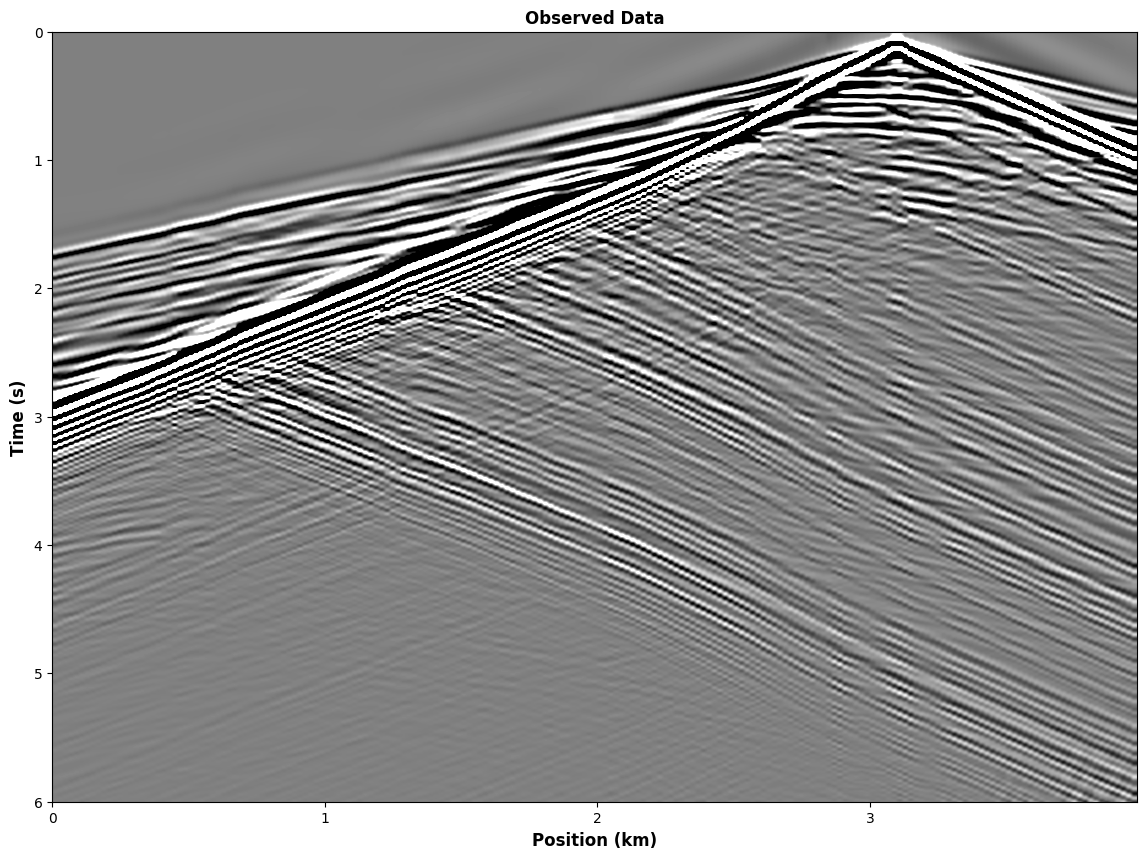

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}
f, ax = plt.subplots(1, 1, figsize=(14, 10), sharey=False)
plt.rc('font', **font)

selected_shot = rcv_amps_true[15,:,:].T
vmin, vmax = torch.quantile(selected_shot,
                            torch.tensor([0.05, 0.95]).to(device))

ax.imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx[1]/1000, selected_shot.shape[0] *(dt), 0])

ax.set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax.set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax.set_title('Observed Data',fontsize='large', fontweight='bold')
#ax.text(0, -0.15, 'a)', fontsize = 12) 
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_xticklabels([])
plt.show()
#f.savefig('Observed_Combined.png', bbox_inches='tight',transparent=True, dpi =100)


(3000.0, 2887.0, 1732.0, 2887.0, 2294.0, 2607.0)

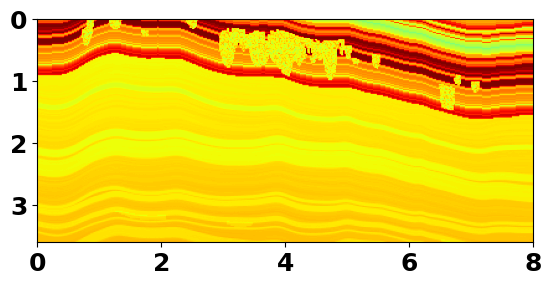

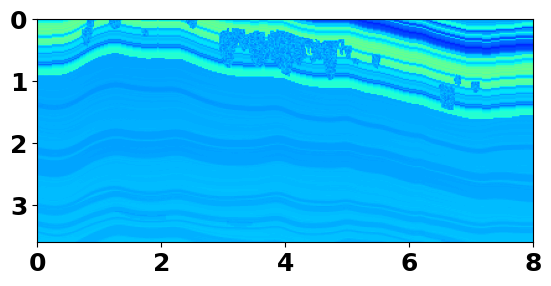

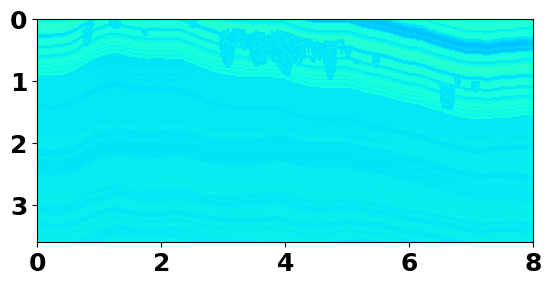

In [7]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3, 4])
box_min = 1140
box_max = 4800

plt.rc('font', **font)


modelp = model_true_vp.detach().cpu().numpy()
im = plt.imshow(modelp, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelp.shape[1] * dx[1] / 1000, modelp.shape[0] * dx[0] / 1000, 0])

plt.figure()
models = model_true_vs.detach().cpu().numpy()
im = plt.imshow(models, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, models.shape[1] * dx[1] / 1000, models.shape[0] * dx[0] / 1000, 0])

plt.figure()
modelrho = model_true_rho.detach().cpu().numpy()
im = plt.imshow(modelrho, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelrho.shape[1] * dx[1] / 1000, modelrho.shape[0] * dx[0] / 1000, 0])

modelp.min(),models.max(), models.min(),models.max(), modelrho.min(), modelrho.max()

## Plotting the inital and true model


(3539.2947, 2563.3599, 2208.5112, 2563.3599, 2432.1787, 2510.3835)

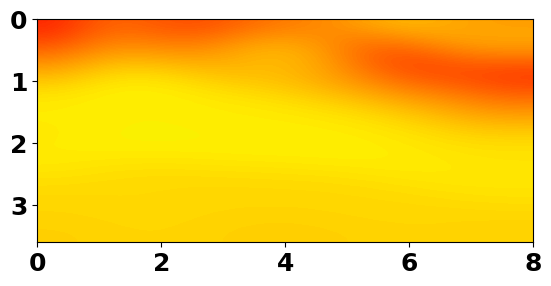

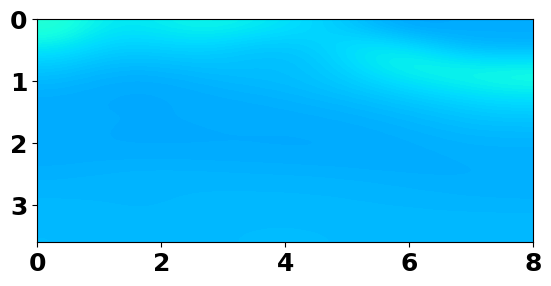

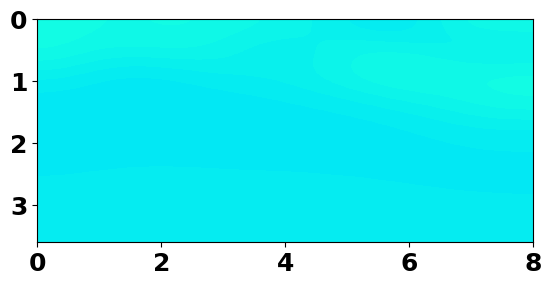

In [8]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3, 4])
box_min = 1140
box_max = 4800

plt.rc('font', **font)


modelp = model_vp.detach().cpu().numpy()
im = plt.imshow(modelp, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelp.shape[1] * dx[1] / 1000, modelp.shape[0] * dx[0] / 1000, 0])

plt.figure()
models = model_vs.detach().cpu().numpy()
im = plt.imshow(models, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, models.shape[1] * dx[1] / 1000, models.shape[0] * dx[0] / 1000, 0])

plt.figure()
modelrho = model_rho.detach().cpu().numpy()
im = plt.imshow(modelrho, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelrho.shape[1] * dx[1] / 1000, modelrho.shape[0] * dx[0] / 1000, 0])

modelp.min(),models.max(), models.min(),models.max(), modelrho.min(), modelrho.max()

In [9]:
box_min1 = model_true_vp.min()
box_max1 = model_true_vp.max()
box_min2 = model_true_vs.min()
box_max2 = model_true_vs.max()
box_min3 = model_true_rho.min()
box_max3 = model_true_rho.max()

(3539.2947, 2563.3599, 2208.5112, 2563.3599, 2432.1787, 2510.3835)

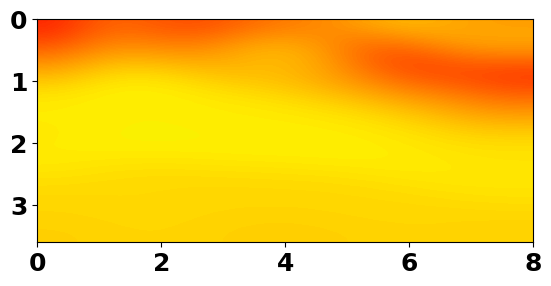

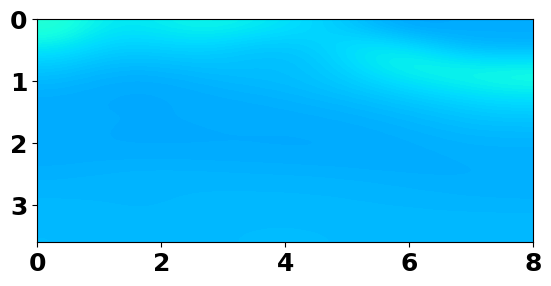

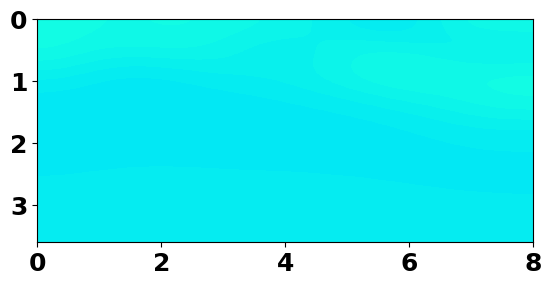

In [10]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3, 4])
box_min = 1140
box_max = 4800

plt.rc('font', **font)


modelp = model_vp.detach().cpu().numpy()
im = plt.imshow(modelp, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelp.shape[1] * dx[1] / 1000, modelp.shape[0] * dx[0] / 1000, 0])

plt.figure()
models = model_vs.detach().cpu().numpy()
im = plt.imshow(models, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, models.shape[1] * dx[1] / 1000, models.shape[0] * dx[0] / 1000, 0])

plt.figure()
modelrho = model_rho.detach().cpu().numpy()
im = plt.imshow(modelrho, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelrho.shape[1] * dx[1] / 1000, modelrho.shape[0] * dx[0] / 1000, 0])

modelp.min(),models.max(), models.min(),models.max(), modelrho.min(), modelrho.max()

## Setting Up the Siamese and Optimizers

In [11]:
from torchsummary import summary
from Model.Module22_644 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 1/2


### optimizer for the velocity model
optimizerp = optim.Adam([{'params': model_vp, 'lr':fwi_lrp, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
optimizers = optim.Adam([{'params': model_vs, 'lr':fwi_lrs, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
optimizerrho = optim.Adam([{'params': model_rho, 'lr':fwi_lrrho, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])

optimizer = torch.optim.LBFGS([model_vp,model_vs,model_rho])
#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

schedulerp = torch.optim.lr_scheduler.MultiplicativeLR(optimizerp, lr_lambda=lr_lambda)
schedulers = torch.optim.lr_scheduler.MultiplicativeLR(optimizers, lr_lambda=lr_lambda)
schedulerrho = torch.optim.lr_scheduler.MultiplicativeLR(optimizerrho, lr_lambda=lr_lambda)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

summary(netD,[(4,nt,num_receivers_per_shot),(4,nt,num_receivers_per_shot)])


############## Init  ################# 
SNRP = 0.0
SSIMP = 0.0
LossP = 0.0
SNRS = 0.0
SSIMS = 0.0
LossS = 0.0
SNRrho = 0.0
SSIMrho = 0.0
Loss = 0.0
ERRORP = 0.0
ERRORS = 0.0
ERRORrho = 0.0




Number of netD params: 5432
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 4, 2000, 199]             148
         LeakyReLU-2         [-1, 4, 2000, 199]               0
            Conv2d-3         [-1, 4, 2000, 199]             148
         LeakyReLU-4         [-1, 4, 2000, 199]               0
            Conv2d-5         [-1, 8, 2000, 199]             296
         LeakyReLU-6         [-1, 8, 2000, 199]               0
            Conv2d-7        [-1, 16, 2000, 199]             592
         LeakyReLU-8        [-1, 16, 2000, 199]               0
            Conv2d-9         [-1, 8, 2000, 199]             296
        LeakyReLU-10         [-1, 8, 2000, 199]               0
           Conv2d-11         [-1, 4, 2000, 199]             148
        LeakyReLU-12         [-1, 4, 2000, 199]               0
           Conv2d-13         [-1, 4, 2000, 199]             148
        Lea

In [12]:
def Xcorr(x,y):
    x = x/torch.norm(x)
    y = y/torch.norm(y)
    loss = -torch.sum(torch.mul(x,y))
    return loss

## Main SiameseFWI

In [13]:
import ptwt
import pywt
import torch.nn.functional as F
# Starting the FWI loop.
global model_vp, model_vs, model_rho, source_amplitudes_init, SNRP, SSIMP, Loss, ERRORS, SNRS, SSIMS, ERRORS, SNRrho, SSIMrho, ERRORrho

import torch.fft



ma = 1/rcv_amps_true.max().detach().cpu().numpy()
con = 10*ma
t_start = time.time()
#model_true = model_true.view(nz,ny)
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
criterion = nn.MSELoss()
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizerps to zero grad.
        optimizerp.zero_grad()
        optimizers.zero_grad()
        optimizerrho.zero_grad()
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        #prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
        #                                  order,survey_pad)
        batch_src_amps = source[it::fwi_batch].to(device)
        batch_rcv_amps_true = rcv_amps_true[it::fwi_batch,:,:].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        #batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred = elastic( *deepwave.common.vpvsrho_to_lambmubuoyancy(model_vp, model_vs,
                                        model_rho),
                                        dx, dt,
                                        source_amplitudes_y=batch_src_amps,
                                        source_locations_y=batch_x_s,
                                        #receiver_locations_y=batch_x_r,
                                        receiver_locations_p = batch_x_r,
                                        accuracy=4,
                                        pml_width=pml_width,
                                        pml_freq=peak_freq)[-3]

        batch_rcv_amps_true = con*batch_rcv_amps_true[0,:,:]
        coefficients = ptwt.wavedec2(batch_rcv_amps_true.T, pywt.Wavelet("haar"),
                                     level=2, mode="zero")
        d_real = torch.cat((coefficients[0][0,:,:].unsqueeze(0),coefficients[1][0][0,:,:].unsqueeze(0),coefficients[1][1][0,:,:].unsqueeze(0),coefficients[1][2][0,:,:].unsqueeze(0)),dim=0).unsqueeze(0)

        
        batch_rcv_amps_pred = con*batch_rcv_amps_pred[0,:,:]
        coefficients = ptwt.wavedec2(batch_rcv_amps_pred.T, pywt.Wavelet("haar"),
                                     level=2, mode="zero")
        d_fake = torch.cat((coefficients[0][0,:,:].unsqueeze(0),coefficients[1][0][0,:,:].unsqueeze(0),coefficients[1][1][0,:,:].unsqueeze(0),coefficients[1][2][0,:,:].unsqueeze(0)),dim=0).unsqueeze(0)


        
        disc_fake, disc_real, o1, o2 = netD(d_real,d_fake)
        loss1 = F.pairwise_distance(o1[0,0,:,:],o2[0,0,:,:], keepdim = True).mean() + 0.3*F.pairwise_distance(o1[0,1,:,:],o2[0,1,:,:], keepdim = True).mean()+ 0.3*F.pairwise_distance(o1[0,2,:,:],o2[0,2,:,:], keepdim = True).mean() + 0.3*F.pairwise_distance(o1[0,3,:,:],o2[0,3,:,:], keepdim = True).mean()
         
        observed_l2_norm = torch.norm(batch_rcv_amps_true, p=2)
        loss = loss1/observed_l2_norm
        

        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp,1e3) 
        torch.nn.utils.clip_grad_value_(model_vs,1e3) 
        torch.nn.utils.clip_grad_value_(model_rho,1e3) 

        # Update the velocity model
        optimizerp.step()
        optimizers.step()
        optimizerrho.step()
        # clip the model value that keep the minimum value is larger than 0
        model_vp.data=torch.clamp(model_vp.data,min=1e-12)
        model_vs.data=torch.clamp(model_vs.data,min=1e-12)
        model_rho.data=torch.clamp(model_rho.data,min=1e-12)


    # Update the learning rate each 200 FWI iterations .
    if (i>0) and (i%100==0):
        schedulerp.step()
        schedulers.step()
        schedulerrho.step()
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizerp.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    #P model
    snrP = ComputeSNR(model_vp.detach().cpu().numpy(),  
              model_true_vp.detach().cpu().numpy())
    SNRP = np.append(SNRP, snrP)

    ssimP = ComputeSSIM(model_vp.detach().cpu().numpy(), \
              model_true_vp.detach().cpu().numpy())
    SSIMP = np.append(SSIMP, ssimP)

    rerrorP = ComputeRE(model_vp.detach().cpu().numpy(), \
              model_true_vp.detach().cpu().numpy())
    ERRORP = np.append(ERRORP, rerrorP)
    
    # S Model
    snrS = ComputeSNR(model_vs.detach().cpu().numpy(),  
              model_true_vs.detach().cpu().numpy())
    SNRS = np.append(SNRS, snrS)

    ssimS = ComputeSSIM(model_vs.detach().cpu().numpy(), \
              model_true_vs.detach().cpu().numpy())
    SSIMS = np.append(SSIMS, ssimS)

    rerrorS = ComputeRE(model_vs.detach().cpu().numpy(), \
              model_true_vs.detach().cpu().numpy())
    ERRORS = np.append(ERRORS, rerrorS)
    
    # Rho model
    snrrho = ComputeSNR(model_rho.detach().cpu().numpy(),  
              model_true_rho.detach().cpu().numpy())
    SNRrho = np.append(SNRrho, snrrho)

    ssimrho = ComputeSSIM(model_rho.detach().cpu().numpy(), \
              model_true_rho.detach().cpu().numpy())
    SSIMrho = np.append(SSIMrho, ssimrho)

    rerrorrho = ComputeRE(model_rho.detach().cpu().numpy(), \
              model_true_rho.detach().cpu().numpy())
    ERRORrho = np.append(ERRORrho, rerrorrho)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR_P:', snrP, 'SSIM_P:', ssimP.cpu().detach().cpu().numpy(), 'SNR_S:', snrS, 'SSIM_S:', ssimS.cpu().detach().cpu().numpy(),  'SNR_rho:', snrrho, 'SSIM_rho:', ssimrho.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'SIAMESERecP_.mat', \
                         {'rec':model_vp.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESERecS_.mat', \
                         {'rec':model_vs.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESERecrho_.mat', \
                         {'rec':model_rho.cpu().data.numpy()}) 
        
        spio.savemat(fwi_result+'SIAMESEMetric_.mat', \
                         {'SNRP':SNRP,'SSIMP':SSIMP, \
                          'Loss':Loss,'ERRORP':ERRORP,
                         'SNRS':SNRS,'SSIMS':SSIMS, 'ERRORS':ERRORS, 'SNRrho':SNRrho,'SSIMrho':SSIMrho,'ERRORrho':ERRORrho}) 
  
# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snrP,ssimP,rerrorP)), fmt='%5.4f') 



Epoch: 1 Loss:  0.02219362910836935 lr_DL: 1e-05 lr_vel: 15 SNR_P: 22.962798240253164 SSIM_P: 0.1988879 SNR_S: 24.368132117389372 SSIM_S: 0.33574665 SNR_rho: 36.051371189867744 SSIM_rho: 0.56465137
Epoch: 2 Loss:  0.01391281415708363 lr_DL: 1e-05 lr_vel: 15 SNR_P: 22.993495770884934 SSIM_P: 0.20075332 SNR_S: 24.548900378941795 SSIM_S: 0.3350191 SNR_rho: 36.05891643128708 SSIM_rho: 0.5670517
Epoch: 3 Loss:  0.009524654247798026 lr_DL: 1e-05 lr_vel: 15 SNR_P: 23.026612671023372 SSIM_P: 0.20300435 SNR_S: 24.70790552565866 SSIM_S: 0.33044356 SNR_rho: 36.080702412420834 SSIM_rho: 0.5692132
Epoch: 4 Loss:  0.007920023566111923 lr_DL: 1e-05 lr_vel: 15 SNR_P: 23.067565185345586 SSIM_P: 0.20537159 SNR_S: 24.841509345508772 SSIM_S: 0.32675916 SNR_rho: 36.10660990646517 SSIM_rho: 0.5710985
Epoch: 5 Loss:  0.007033553323708475 lr_DL: 1e-05 lr_vel: 15 SNR_P: 23.1105832975009 SSIM_P: 0.2075842 SNR_S: 24.96476886662649 SSIM_S: 0.32351148 SNR_rho: 36.1366409656353 SSIM_rho: 0.57270855
Epoch: 6 Loss:  

Epoch: 43 Loss:  0.0029924889793619515 lr_DL: 1e-05 lr_vel: 15 SNR_P: 24.567544863482563 SSIM_P: 0.30999842 SNR_S: 27.084409976724224 SSIM_S: 0.4004264 SNR_rho: 36.39445689303787 SSIM_rho: 0.5720601
Epoch: 44 Loss:  0.0028762510453816505 lr_DL: 1e-05 lr_vel: 15 SNR_P: 24.59587481717207 SSIM_P: 0.31227908 SNR_S: 27.12467058104042 SSIM_S: 0.4018771 SNR_rho: 36.397895066654165 SSIM_rho: 0.5719713
Epoch: 45 Loss:  0.0028554088494274765 lr_DL: 1e-05 lr_vel: 15 SNR_P: 24.625416203093174 SSIM_P: 0.31452534 SNR_S: 27.15917347489183 SSIM_S: 0.4041562 SNR_rho: 36.39385869320671 SSIM_rho: 0.571723
Epoch: 46 Loss:  0.0027356736012734474 lr_DL: 1e-05 lr_vel: 15 SNR_P: 24.653840876747218 SSIM_P: 0.3165953 SNR_S: 27.19101224850213 SSIM_S: 0.40601438 SNR_rho: 36.3949959359202 SSIM_rho: 0.5713909
Epoch: 47 Loss:  0.0027177627955097703 lr_DL: 1e-05 lr_vel: 15 SNR_P: 24.682097942639103 SSIM_P: 0.31889313 SNR_S: 27.230254966444747 SSIM_S: 0.4069136 SNR_rho: 36.40132412537751 SSIM_rho: 0.571015
Epoch: 48 L

Epoch: 85 Loss:  0.002323848952073604 lr_DL: 1e-05 lr_vel: 15 SNR_P: 25.557184683172398 SSIM_P: 0.38275272 SNR_S: 28.191876573609946 SSIM_S: 0.44968593 SNR_rho: 36.479189445606345 SSIM_rho: 0.56905556
Epoch: 86 Loss:  0.0022540036879945546 lr_DL: 1e-05 lr_vel: 15 SNR_P: 25.57638845211326 SSIM_P: 0.3839813 SNR_S: 28.21073415629771 SSIM_S: 0.4504711 SNR_rho: 36.48620660933084 SSIM_rho: 0.5693175
Epoch: 87 Loss:  0.0023048345086863265 lr_DL: 1e-05 lr_vel: 15 SNR_P: 25.594757388645416 SSIM_P: 0.38536912 SNR_S: 28.230745399603233 SSIM_S: 0.45141658 SNR_rho: 36.485511866187224 SSIM_rho: 0.569207
Epoch: 88 Loss:  0.002235473325708881 lr_DL: 1e-05 lr_vel: 15 SNR_P: 25.613677333808432 SSIM_P: 0.3865232 SNR_S: 28.249017062841922 SSIM_S: 0.4521891 SNR_rho: 36.49256995409801 SSIM_rho: 0.5694034
Epoch: 89 Loss:  0.002286572431330569 lr_DL: 1e-05 lr_vel: 15 SNR_P: 25.63162958681037 SSIM_P: 0.38793886 SNR_S: 28.268795957040595 SSIM_S: 0.45313314 SNR_rho: 36.49202844433909 SSIM_rho: 0.56912875
Epoch: 

Epoch: 126 Loss:  0.0011293925199424848 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.07877028922221 SSIM_P: 0.4192569 SNR_S: 28.794577955569487 SSIM_S: 0.4814446 SNR_rho: 36.617021906399806 SSIM_rho: 0.5771093
Epoch: 127 Loss:  0.0014422903739614412 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.087523462597197 SSIM_P: 0.41970205 SNR_S: 28.807060157519384 SSIM_S: 0.4822065 SNR_rho: 36.619003567993175 SSIM_rho: 0.57730556
Epoch: 128 Loss:  0.0014165318658342584 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.09645930733023 SSIM_P: 0.42030635 SNR_S: 28.817412257997486 SSIM_S: 0.48298052 SNR_rho: 36.621188871242786 SSIM_rho: 0.57756263
Epoch: 129 Loss:  0.001335770045989193 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.105793379285778 SSIM_P: 0.42091283 SNR_S: 28.827213629836002 SSIM_S: 0.4835777 SNR_rho: 36.626642312532894 SSIM_rho: 0.57777107
Epoch: 130 Loss:  0.0012562050425913185 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.11457937872299 SSIM_P: 0.42162272 SNR_S: 28.837594808750175 SSIM_S: 0.48399588 SNR_rho: 36.630163826751215 SSIM_rho: 

Epoch: 167 Loss:  0.0012673589866608382 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.414856050532272 SSIM_P: 0.4416479 SNR_S: 29.177827931713534 SSIM_S: 0.50237685 SNR_rho: 36.753346635967176 SSIM_rho: 0.586612
Epoch: 168 Loss:  0.0011859756079502404 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.42283407010806 SSIM_P: 0.44211122 SNR_S: 29.183994880611152 SSIM_S: 0.502915 SNR_rho: 36.75872641647966 SSIM_rho: 0.5867637
Epoch: 169 Loss:  0.0012443798797903583 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.429576066117 SSIM_P: 0.44250813 SNR_S: 29.193230704571466 SSIM_S: 0.5032841 SNR_rho: 36.7599351540779 SSIM_rho: 0.586865
Epoch: 170 Loss:  0.001186028218944557 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.437362446380746 SSIM_P: 0.44299543 SNR_S: 29.199191060771653 SSIM_S: 0.5037321 SNR_rho: 36.76515154573821 SSIM_rho: 0.58718204
Epoch: 171 Loss:  0.001222958933794871 lr_DL: 1e-05 lr_vel: 7.5 SNR_P: 26.444055570475918 SSIM_P: 0.44345096 SNR_S: 29.208324490907142 SSIM_S: 0.50409627 SNR_rho: 36.766370244501154 SSIM_rho: 0.58731467


In [14]:
from math import sqrt
rms_vp = sqrt(np.mean(((model_true_vp.detach().cpu().numpy()-model_vp.detach().cpu().numpy())/1000)**2))
rms_vs = sqrt(np.mean(((model_true_vs.detach().cpu().numpy()-model_vs.detach().cpu().numpy())/1000)**2))
rms_rho = sqrt(np.mean(((model_true_rho.detach().cpu().numpy()-model_rho.detach().cpu().numpy())/1000)**2))
rms_vp, rms_vs, rms_rho

(0.1736621385660229, 0.07735335020729797, 0.03522569863295897)

## Plotting the Reconstructed Velocity Model

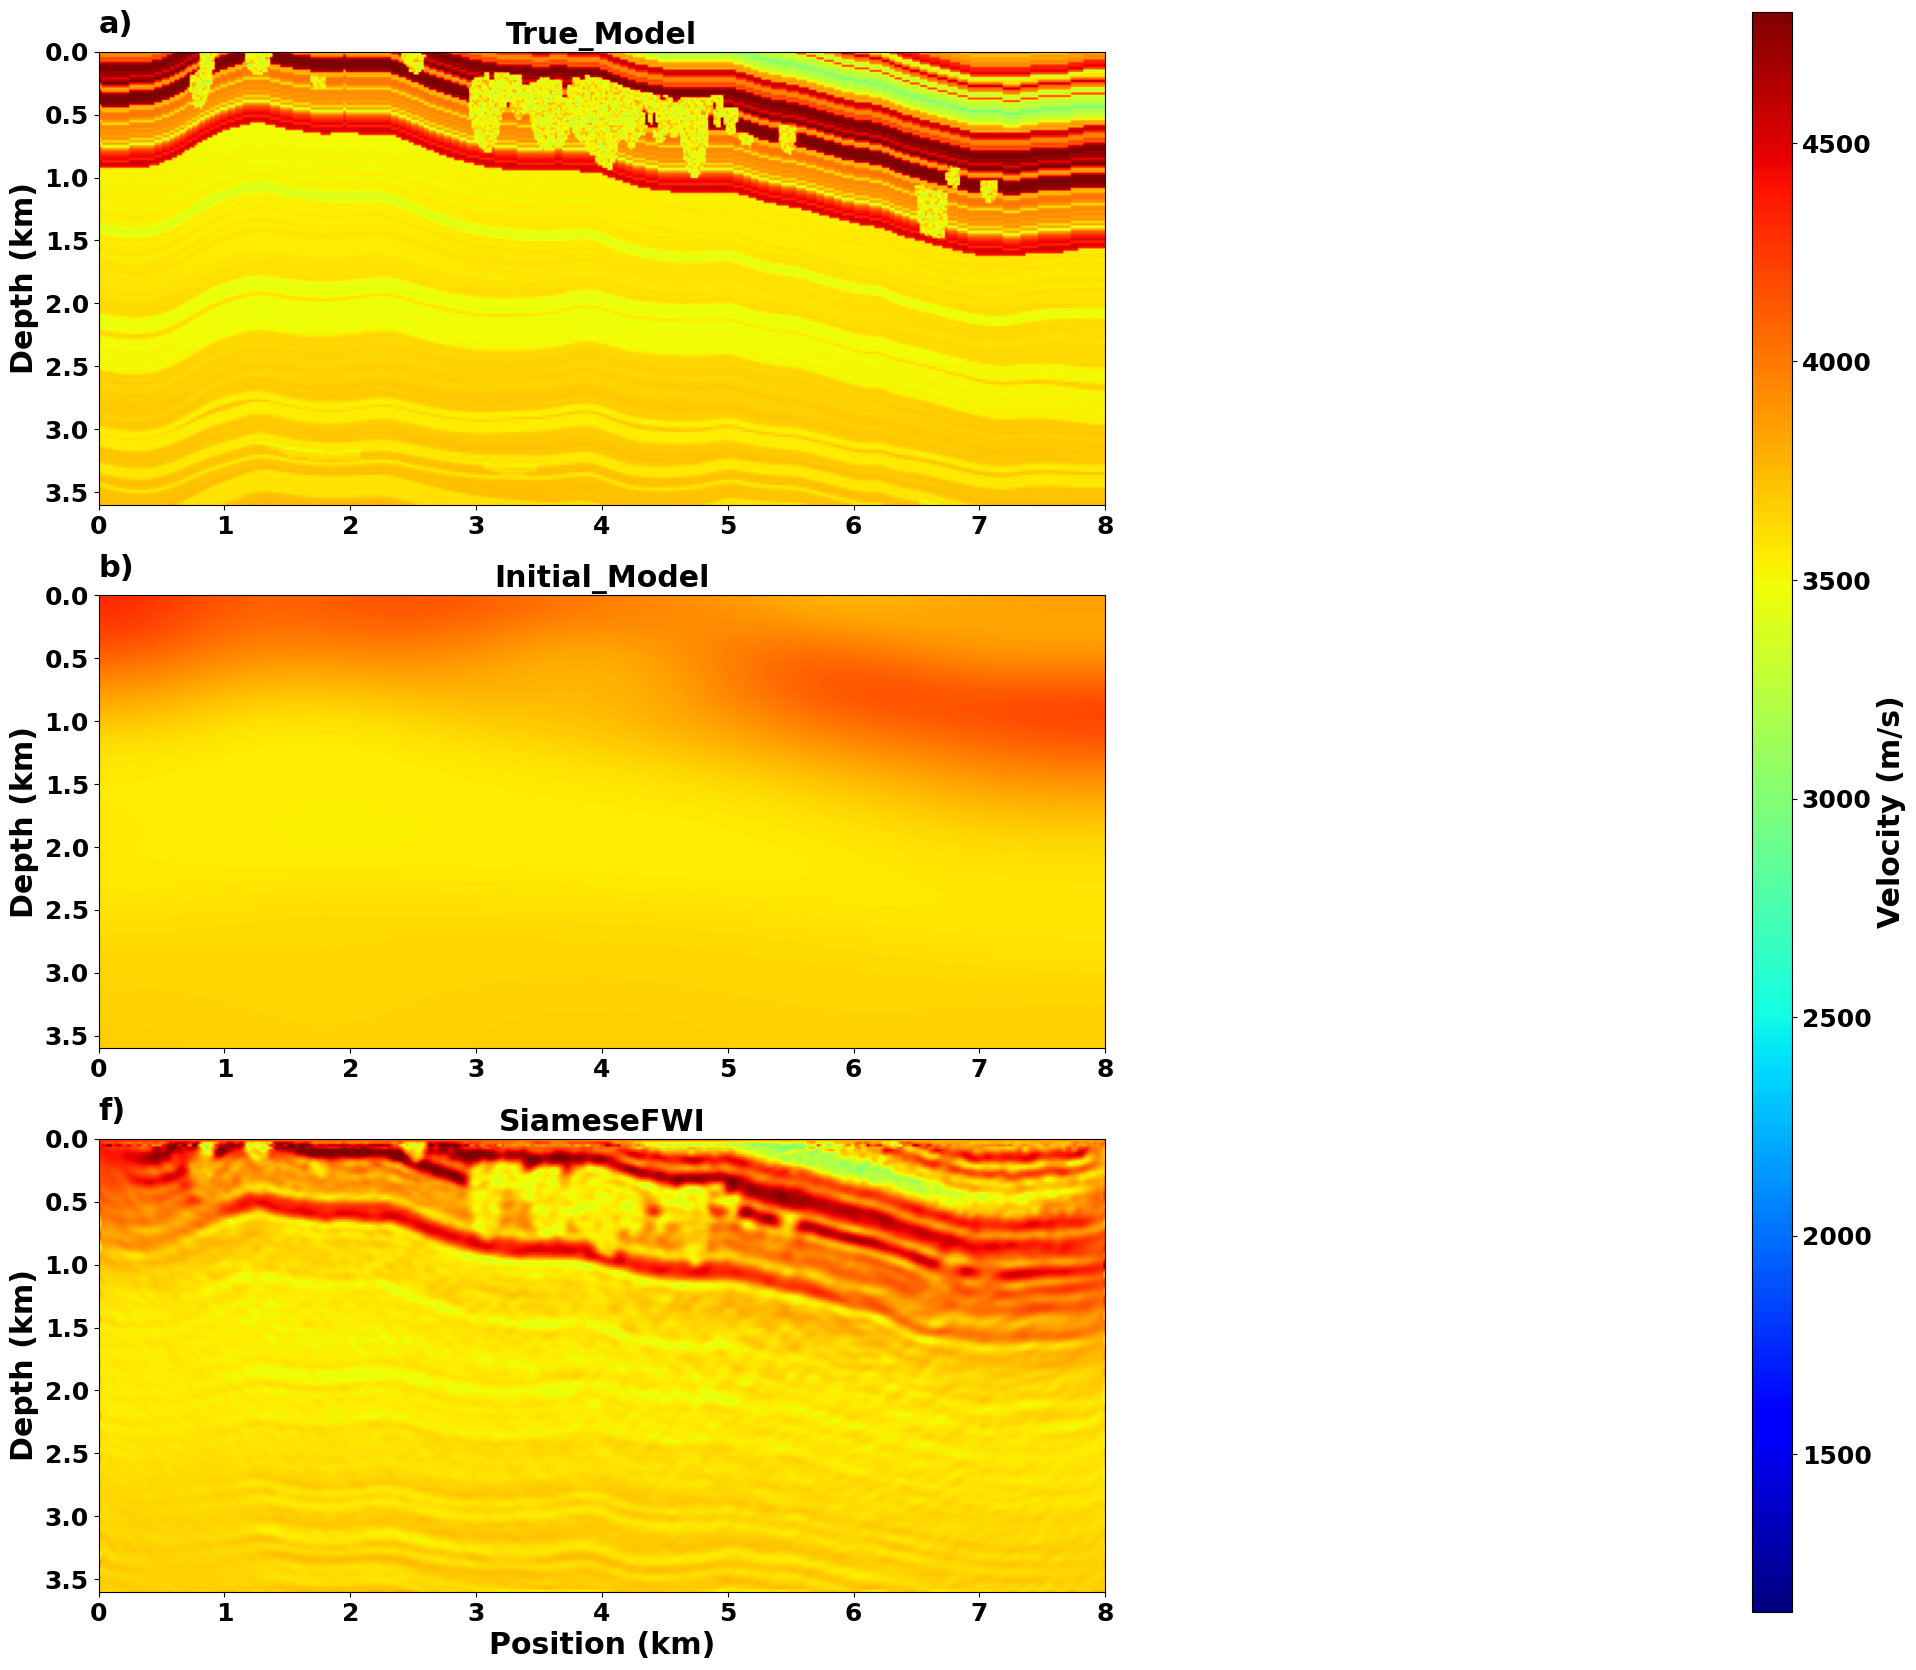

The reconstructed velocity model has SNR: 26.640863112716335 dB and SSIM: 0.4559119


In [15]:
f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model_true_vp.detach().cpu().numpy()
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx[1] / 1000, modeltrue.shape[0] * dx[0] / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init_vp.detach().cpu().numpy()
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx[1] / 1000, init_V.shape[0] * dx[0] / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERecP_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx[1] / 1000, Siamese_Vel.shape[0] * dx[0] / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()

snr = ComputeSNR(Siamese_Vel,  
          model_true_vp.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true_vp.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))

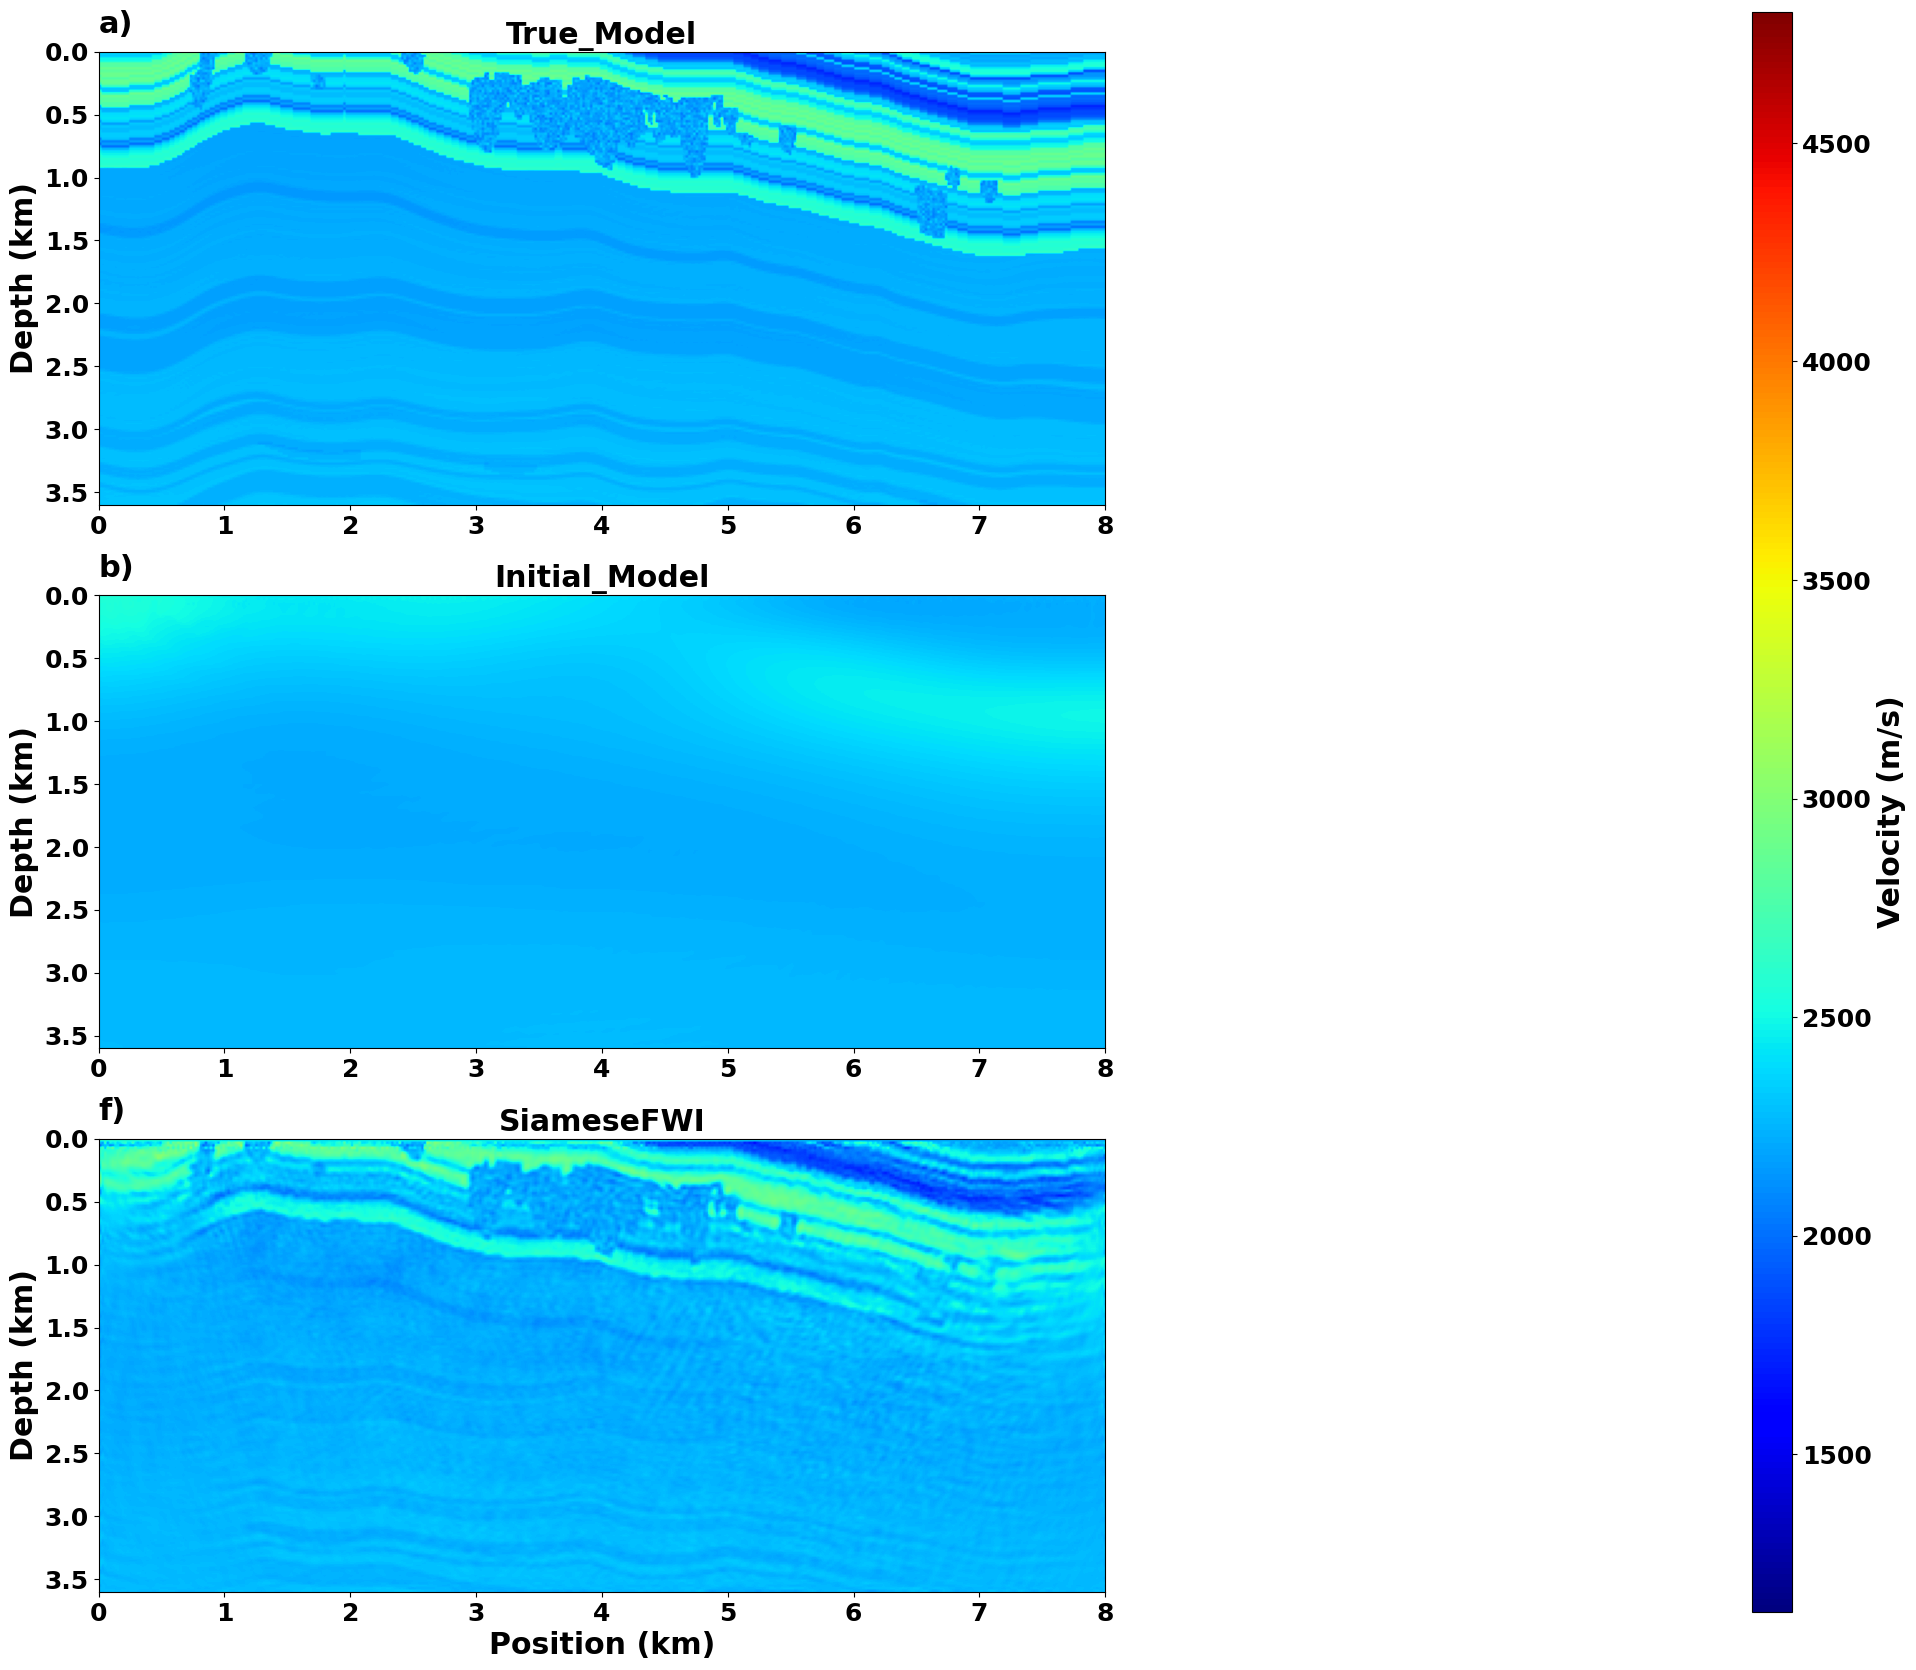

The reconstructed velocity model has SNR: 29.408160860303802 dB and SSIM: 0.5147307


In [16]:
f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model_true_vs.detach().cpu().numpy()
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx[0] / 1000, modeltrue.shape[0] * dx[0] / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init_vs.detach().cpu().numpy()
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx[1] / 1000, init_V.shape[0] * dx[0] / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERecS_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx[1] / 1000, Siamese_Vel.shape[0] * dx[0] / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()

snr = ComputeSNR(Siamese_Vel,  
          model_true_vs.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true_vs.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))

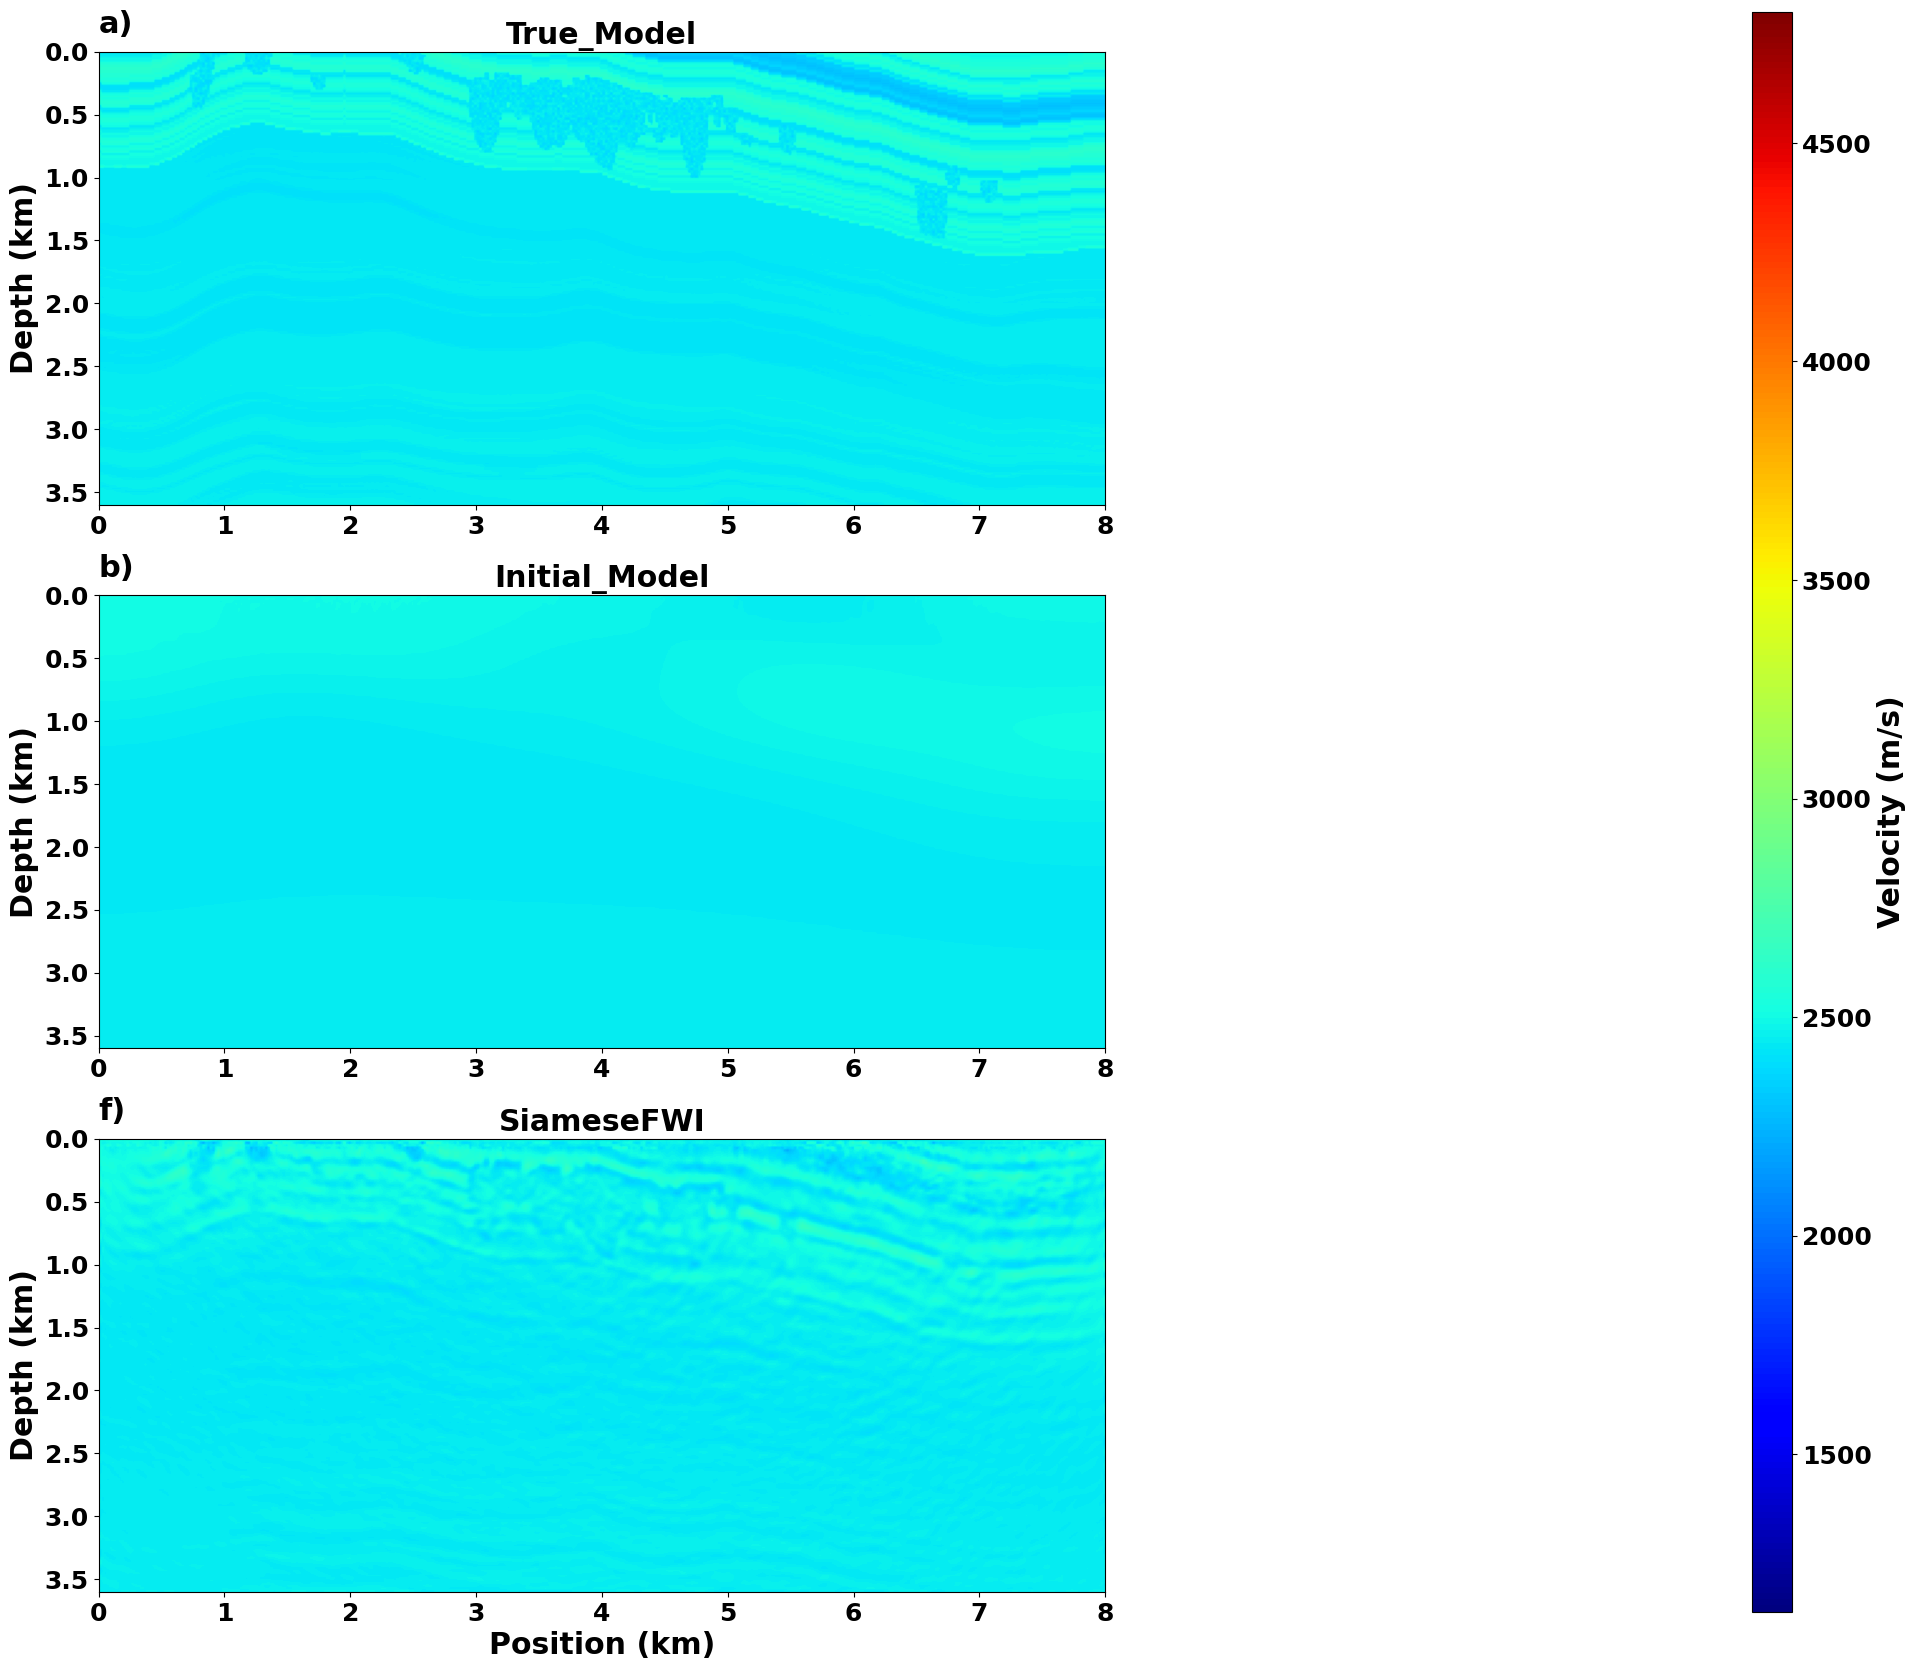

The reconstructed velocity model has SNR: 36.86302840822751 dB and SSIM: 0.5934258


In [17]:
f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model_true_rho.detach().cpu().numpy()
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx[1] / 1000, modeltrue.shape[0] * dx[0] / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init_rho.detach().cpu().numpy()
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx[1] / 1000, init_V.shape[0] * dx[0] / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERecrho_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx[1] / 1000, Siamese_Vel.shape[0] * dx[0] / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()

snr = ComputeSNR(Siamese_Vel,  
          model_true_rho.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true_rho.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))

In [18]:
torch.save(netD.state_dict(), fwi_result + 'netD')
netD = torch.load(fwi_result + 'netD')